In [358]:
# Necessary Libraries
import re
import os
import unidecode
import ast
import nltk
import csv
import apify_client
import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import compare_communities

from typing import Dict, Any
from apify_client import ApifyClient
from plotly.subplots import make_subplots
from datetime import datetime
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
from string import punctuation

# Downloading popular corpus
nltk.download("popular")
# Defining stopwords in English Language
sw_en = stopwords.words('spanish')
# Defining Lemmatizer with WordNet
nltk.download("wordnet")
wlem = WordNetLemmatizer()
# Defining Word Tokenizer
tokenizer = WordPunctTokenizer()
# Defining Stemmer
sst = SnowballStemmer(language='spanish')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/namadoa/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/namadoa/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/namadoa/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/namadoa/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/namadoa/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/namadoa/nltk_data...
[nltk_data]    |   Package movie_reviews is already

In [369]:
# Constants
APIFY_KEY = ""
TAGS_TWITTER = ["#NevadoDelRuiz", "#VolcanNevadoDelRuiz"]
TWITTER_CSV_PATH = "./twitter_requested_dataset.csv"
DEBUG = False

#### Request Twitter Data

In [ ]:
# Initialize the ApifyClient with your API token
client = ApifyClient(APIFY_KEY)

# Prepare the actor input
run_input = {
    "searchTerms": TAGS_TWITTER,
    "searchMode": "live",
    "profilesDesired": 10,
    "tweetsDesired": 2000,
    "mode": "replies",
    "proxyConfig": { "useApifyProxy": True },
    "extendOutputFunction": """async ({ data, item, page, request, in_reply_to_user_id, customData, Apify }) => {
  return item;
}""",
    "extendScraperFunction": """async ({ page, request, addSearch, addProfile, _, addThread, addEvent, customData, Apify, signal, label }) => {
 
}""",
    "customData": {},
    "handlePageTimeoutSecs": 500,
    "maxRequestRetries": 6,
    "maxIdleTimeoutSecs": 60,
}

# Run the actor and wait for it to finish
run = client.actor("quacker/twitter-scraper").call(run_input=run_input)

In [266]:
# Utils Functions

def flatten(list_of_lists):
    """Takes a list of lists and turns it into a list of the sub-elements"""
    return [item for sublist in list_of_lists if type(sublist) == list for item in sublist]

def get_most_used(values, rank=1):
    if len(set(values)) < rank: return None
    counts = [(v, values.count(v)) for v in set(values)]
    counts.sort(key=lambda t: t[1], reverse=True)
    return counts[rank-1][0]

def read_tweets(file_path: str):
    tweets = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            tweets.append(obj)
    return tweets

def extract_parent_dir(filepath, default_dir='./'):
    if not filepath:
        return default_dir

    return os.path.abspath(os.path.join(filepath, os.pardir))

def log(msg):
    if DEBUG: eprint(msg)

In [356]:
# Necessary functions

def mentioned_ids_from(tweet, desired_field='id_str'):
    try:
        mention_entities = ast.literal_eval(tweet)
        return [mention[desired_field] for mention in mention_entities]
    except KeyError as e:
        print(f"KeyError {e}")

def expanded_urls_from(tweet):
    try:
        url_entities = [url_entity['url'] for 
                        url_entity in ast.literal_eval(tweet)]
        return url_entities
    except KeyError as e:
        print(f"KeyError {e}")
        
def lowered_hashtags_from(tweet):
    try:
        ht_entities = ast.literal_eval(tweet)
        ht_entities_formatted = [ht.lower() 
                                 for ht in ht_entities]
        return ht_entities_formatted
    except KeyError as e:
        print(f"KeyError {e}")

        
def analyse_tweet_data(tweets_dataset: pd.DataFrame) -> Dict[str, Any]:
    
    # Copying Datasets
    tweets_dataset = tweets_dataset.copy()
    
    # Defining Dict Result
    dict_result = {}
    # Data Understanding
    ## Metrics
    tweets_dataset['mentions'] = tweets_dataset['user_mentions'].apply(mentioned_ids_from)
    tweets_dataset['hashtags'] = tweets_dataset['hashtags'].apply(lowered_hashtags_from)
    tweets_dataset['urls'] = tweets_dataset['urls'].apply(expanded_urls_from)
    tweets_dataset['hashtags_count'] = [len(i) if i != None else None 
                                        for i in tweets_dataset['hashtags']
                                        .tolist()]

    tweets_dataset['urls_count'] = [len(i) if i != None else None 
                                    for i in tweets_dataset['urls']
                                    .tolist()]

    tweets_dataset['author_id'] = tweets_dataset['user'].apply(ast.literal_eval).apply(lambda x: x['id'])
    all_authors = [i for i in tweets_dataset['author_id'].tolist()
                  if type(i) != float]
    all_mentions = flatten(tweets_dataset['mentions'].tolist())
    all_hashtags = flatten(tweets_dataset['hashtags'].tolist())
    all_urls = flatten(tweets_dataset['urls'].tolist())

    tweets_count = tweets_dataset.shape[0]
    retweet_count = tweets_dataset['retweet_count'].sum()
    reply_count = tweets_dataset['reply_count'].sum()
    favorite_count = tweets_dataset['favorite_count'].sum()
    view_count = tweets_dataset['view_count'].sum()

    hashtags_amount =  tweets_dataset['hashtags_count'].sum()
    urls_amount = tweets_dataset['urls_count'].sum()

    most_profilic_author = get_most_used(all_authors)
    most_prolific_author_tweet_count = all_authors.count(most_profilic_author)

    most_mentioned_author = get_most_used(all_mentions)
    most_mentioned_author_count = all_mentions.count(most_mentioned_author)

    unique_hashtags = len(set(all_hashtags))
    most_used_hashtag = get_most_used(all_hashtags)
    most_used_hashtag_count = all_hashtags.count(most_used_hashtag)
    next_most_used_hashtag = get_most_used(all_hashtags, 2)
    next_most_used_hashtag_count = all_hashtags.count(next_most_used_hashtag)

    most_used_url = get_most_used(all_urls)
    most_used_url_count = all_urls.count(most_used_url)
    
    # Setting dict variables
    dict_result['tweets_count'] = tweets_count
    dict_result['retweet_count'] = retweet_count
    dict_result['reply_count'] = reply_count
    dict_result['favorite_count'] = favorite_count
    dict_result['view_count'] = view_count
    dict_result['hashtags_amount'] = hashtags_amount
    dict_result['urls_amount'] = urls_amount
    dict_result['most_profilic_author'] = most_profilic_author
    dict_result['most_prolific_author_tweet_count'] = most_prolific_author_tweet_count
    dict_result['most_mentioned_author_count'] = most_mentioned_author_count
    dict_result['unique_hashtags'] = unique_hashtags
    dict_result['most_used_hashtag'] = most_used_hashtag
    dict_result['most_used_hashtag_count'] = most_used_hashtag_count
    dict_result['next_most_used_hashtag'] = next_most_used_hashtag
    dict_result['next_most_used_hashtag_count'] = next_most_used_hashtag_count
    dict_result['most_used_url'] = most_used_url
    dict_result['most_used_url_count'] = most_used_url_count 
    
    return dict_result

def create_digraph_from_csv_file(csv_file: str, src_col,
                                 tgt_col, type_col, out_file,
                                 header, src_type, tgt_type, ci):
    g = nx.DiGraph()
    with open(csv_file, encoding='utf-8') as f:
        csv_reader = csv.reader(f, delimiter=',')   # handles URLs with commas
        line_count = 0
        for row in csv_reader:
            # print('linecount: %d, header: %s' % (line_count, header))
            line_count += 1
            if line_count == 1 and header:
                continue

            src = row[src_col]
            tgt = row[tgt_col]
            e_t = row[type_col]

            if ci:
                src = src.lower()
                tgt = tgt.lower()
            if src != "usr_id":
                if g.has_edge(src, tgt):
                    g[src][tgt]['weight'] += 1.0
                else:
                    if not g.has_node(src): g.add_node(src, label=src, n_type=src_type)
                    if not g.has_node(tgt): g.add_node(tgt, label=tgt, n_type=tgt_type)
                    g.add_edge(src, tgt, weight=1.0, e_type=e_t)

            line_count += 1

    if not out_file:
        out_file = os.path.join(out_dir, '%s.graphml' % extract_filename(csv_file))
    parent_dir = extract_parent_dir(out_file)
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    nx.write_graphml(g, out_file)
    df_graph = nx.to_pandas_edgelist(g)
    df_graph.to_csv(f'{out_file}.csv', index=False)

    log('Wrote graph to %s' % out_file)
    
def save_tweets_pairs_txt_format(tweets_dataset, col_1, col_2, type_tweets):
    mentions_dict_dataset = []
    for i in range(len(tweets_dataset)):
        user_id = tweets_dataset.loc[i, col_1]
        mentions = tweets_dataset.loc[i, col_2]
        if (type(mentions) == list):
            for mention in mentions:
                mentions_dict_dataset.append({str(user_id): mention})
        else:
            mentions_dict_dataset.append({str(user_id): mentions})
            
    for row in mentions_dict_dataset:
        with open(f'tweets-{type_tweets}.txt', 'a') as convert_file:
            for key, value in row.items():
                 convert_file.write('%s,%s\n' % (key, value))

def filter_by_str_contains(tweet_dataset: pd.DataFrame,
                           text_column: str,
                           token: str) -> pd.DataFrame:
    tweet_dataset_to_be_filtered = tweet_dataset.copy()
    tweet_dataset_to_be_filtered = (
        tweet_dataset_to_be_filtered
        [text_column].str.contains(token)
    )
    return tweet_dataset_to_be_filtered
    
def preprocess(df_preprocessed: pd.DataFrame,
               text_column: str
              ):
    """ This function allow preprocess toxic comments"""

    regex_query = r'((http*\S+)|(#\S+)|(@\S+))|([^a-zA-Z\s+])|(\n)'
    text = df_preprocessed.copy()
    # Deleting extra espaces, lowering texts and unidecoding
    text[f'{text_column}_preprocessed'] = [unidecode.unidecode(i).lower().strip() for i in
                                           text[text_column]]
    # Applying regex query
    text[f'{text_column}_preprocessed'] = (
        text[f'{text_column}_preprocessed']
        .str.replace(regex_query, '', regex=True)
        .replace('\s+', ' ',regex=True)
    )

    text['tokenized_message'] = [tokenizer.tokenize(
        i) for i in text[f'{text_column}_preprocessed']]
    text['stemming_stopwords'] = text['tokenized_message'].apply(
        lambda x: " ".join([sst.stem(y) for y in x if y not in sw_en]))  # Stem every word.
    text['lemmatization_stopwords'] = text['tokenized_message'].apply(
        lambda x: " ".join([wlem.lemmatize(y) for y in x if y not in sw_en]))

    return text


def feature_extraction(corpus_df: pd.DataFrame, 
                       text_column: str) -> pd.DataFrame:
    
    # Joining corpus texts
    all_words = " ".join(corpus_df[text_column])
    # Defining the vocabulary
    vocab = list(set(all_words.split()))
    # Create dictionary of hash words.
    
    hashes = {word: i for i, word in enumerate(vocab)}
    # Count the lemma tokens in each text
    counts = [
        Counter(doc.split())
        for doc in corpus_df[text_column]
        ]
    
    # Defining Bag of Words shape
    bow_shape = (corpus_df.shape[0], len(vocab))
    X = np.zeros(
            shape=bow_shape,
            dtype="uint32"
        )

    for i, doc_count in enumerate(counts):
        words, freqs = (
                list(doc_count.keys()),
                list(doc_count.values())
                )
        doc_hash = [hashes[word] for word in words]
        X[i, doc_hash] = freqs
        
    counter_dataset = (
        pd.DataFrame(X, columns=vocab)
        .assign(texto = corpus_df[text_column])
    )

    return counter_dataset

In [ ]:
# Fetch and store tweet results from the run's dataset (if there are any)
tweets_requested = []
for tweet_requested in client.dataset(run["defaultDatasetId"]).iterate_items():
    tweets_requested.append(tweet_requested)

In [ ]:
# Create twitter dataset
tweets_dataset = pd.DataFrame(tweets_requested)

In [ ]:
# Saving twitter dataset
tweets_dataset.to_csv(TWITTER_CSV_PATH, index=False)

In [43]:
# Reading saved dataset
tweets_dataset = pd.read_csv(TWITTER_CSV_PATH)

### Analyze data

In [44]:
# Cleaning 'created_at' column.
tweets_dataset_normalized = (
    tweets_dataset.assign(
        created_at = lambda df: pd.to_datetime(df['created_at']),
        month = lambda df: df['created_at'].dt.month,
        year = lambda df: df['created_at'].dt.year
    )
)

In [83]:
# Grouping tweets dataset
tweets_dataset_normalized_grouped = (
    tweets_dataset_normalized.groupby(
        ['year', 'month']
    )
    ['id']
    .count()
    .reset_index()
    .rename(columns={'id': 'tweets_count'})
)

# Pivoting tweets dataset
tweets_dataset_pivoted = (
    pd.pivot_table(
        tweets_dataset_normalized_grouped,
        values=['tweets_count'],
        index=['year'],
        columns=['month'],
        fill_value=0
    )
)

# Plotting Heatmap
fig = px.imshow(tweets_dataset_pivoted.values, 
                labels=dict(x="Month", y="Year", color="Amount of tweets"),
                x=sorted(hashtag_dataset_grouped.month.unique().tolist()),
                y=sorted(hashtag_dataset_grouped.year.unique().tolist()),
                text_auto=True)
fig.show()

In [84]:
# Creating Hashtag Dataset
hashtags_twitter_dictionary_list = []
for i in range(len(tweets_dataset_normalized)):
    hashtags_list = ast.literal_eval(
        tweets_dataset_normalized['hashtags'].iloc[i]
    )
    date = datetime(tweets_dataset_normalized['year'].iloc[i],
                    tweets_dataset_normalized['month'].iloc[i],
                    1)
    for hashtag in hashtags_list:
        hashtags_twitter_dictionary_list.append(
            {
                'date': date,
                'hashtag': hashtag
            }
        )

# Defining Hashtag Dataset
hashtag_dataset = (
    pd.DataFrame(hashtags_twitter_dictionary_list)
    .assign(
        year=lambda df: df['date'].dt.year,
        month=lambda df: df['date'].dt.month
    )
)

# Grouping tweets dataset
hashtag_dataset_grouped = (
    hashtag_dataset.groupby(
        ['year', 'month']
    )
    ['hashtag']
    .count()
    .reset_index()
    .rename(columns={'hashtag': 'hashtag_count'})
)

# Pivoting tweets dataset
hashtag_dataset_pivoted = (
    pd.pivot_table(
        hashtag_dataset_grouped,
        values=['hashtag_count'],
        index=['year'],
        columns=['month'],
        fill_value=0
    )
)

# Plotting Heatmap
fig = px.imshow(hashtag_dataset_pivoted.values, 
                labels=dict(x="Month", y="Year", color="Amount of hashtags"),
                x=sorted(hashtag_dataset_grouped.month.unique().tolist()),
                y=sorted(hashtag_dataset_grouped.year.unique().tolist()),
                text_auto=True)
fig.show()

In [91]:
# Second grouped dataset
tweets_dataset_normalized_grouped_series_plot = (
    tweets_dataset_normalized.assign(
        created_at_new = lambda df: df.apply(lambda x: datetime(x['year'], x['month'], 1),
                                             axis=1)
    )
    .groupby(
        ['created_at_new']
    )
    ['id']
    .count()
    .reset_index()
    .rename(columns={'id': 'tweets_count'})
    .sort_values(by='created_at_new')
    .assign(
        tweets_count_cumsum=lambda df: df['tweets_count'].cumsum()
    )
)

# set up plotly figure
fig = make_subplots(1,1)

# add first bar trace at row = 1, col = 1
fig.add_trace(go.Bar(x=tweets_dataset_normalized_grouped_series_plot['created_at_new'], 
                     y=tweets_dataset_normalized_grouped_series_plot['tweets_count'],
                     name='A',
                     marker_color = 'green',
                     opacity=0.4,
                     marker_line_color='rgb(8,48,107)',
                     marker_line_width=2),
              row = 1, col = 1)

# add first scatter trace at row = 1, col = 1
fig.add_trace(go.Scatter(x=tweets_dataset_normalized_grouped_series_plot['created_at_new'], 
                         y=tweets_dataset_normalized_grouped_series_plot['tweets_count_cumsum'], 
                         line=dict(color='red'), name='B'),
              row = 1, col = 1)

fig.show()

In [90]:
# Second grouped dataset
tweets_dataset_normalized_grouped_series_plot = (
    hashtag_dataset
    .groupby(
        ['date']
    )
    ['hashtag']
    .count()
    .reset_index()
    .rename(columns={'hashtag': 'hashtags_count'})
    .sort_values(by='date')
    .assign(
        hashtags_count_cumsum=lambda df: df['hashtags_count'].cumsum()
    )
)

# set up plotly figure
fig = make_subplots(1,1)

# add first bar trace at row = 1, col = 1
fig.add_trace(go.Bar(x=tweets_dataset_normalized_grouped_series_plot['date'], 
                     y=tweets_dataset_normalized_grouped_series_plot['hashtags_count'],
                     name='A',
                     marker_color = 'green',
                     opacity=0.4,
                     marker_line_color='rgb(8,48,107)',
                     marker_line_width=2),
              row = 1, col = 1)

# add first scatter trace at row = 1, col = 1
fig.add_trace(go.Scatter(x=tweets_dataset_normalized_grouped_series_plot['date'], 
                         y=tweets_dataset_normalized_grouped_series_plot['hashtags_count_cumsum'], 
                         line=dict(color='red'), name='B'),
              row = 1, col = 1)

fig.show()

In [109]:
# Count top 15 of hashtags
hashtag_dataset_top_15_count = (
    hashtag_dataset['hashtag']
    .value_counts()
    .iloc[:15]
    .reset_index()
)

# Plotting Bar Diagram
px.bar(hashtag_dataset_top_15_count, x='count', y='hashtag')

**Commentary**: We have data since 2011, how we can see the amount of tweets associated with the Nevado del Ruiz volcano is lower compared with the current year, and it is normal, currently we have an alarm and the volcano is the center of discussion nowdays.

### Preprocessing data

In [112]:
# Filtering data by year.
## Year: 2022-2023
tweets_dataset_temporal_filtered = (
    tweets_dataset_normalized
    .query('(year >= 2022)')
)

**Commentary**: We decided to split the data into 2022 & 2023 years, this to analyze how much increased the interest related with the Nevado del Ruiz volcano increased.

In [188]:
# Processing texts
tweets_dataset_normalized = (
    preprocess(tweets_dataset_temporal_filtered, 'full_text')
)

# Creating bag of words for the tweets dataset
bag_of_words_tweets_dataset = feature_extraction(tweets_dataset_normalized, 'lemmatization_stopwords')

# Defining count of words dataset
count_of_words_dataset = (
    bag_of_words_tweets_dataset.iloc[:, :-1].T.sum(axis=1)
    .reset_index()
    .rename(columns={'index': 'tokens',
                     0: 'count'})
    .sort_values(by='count', ascending=False)
)

In [196]:
# It is the top 10 of most common words in the tweets.
count_of_words_dataset_top_10 = count_of_words_dataset.iloc[:10]

# Plotting Bar Diagram
px.bar(count_of_words_dataset_top_10, x='count', y='tokens')

**Comment**: Taking in account the most used tokens on the tweets, we are going to define a list of tokens that we consider are related with the current emergency to filter it out.

In [204]:
# Most common identified from tweets.
most_common_tokens = ['erupcion', 'actividad', 'alerta', 'riesgo', 'ceniza', 'informacion',
                      'naranja', 'zona', 'evacuacion', 'emergencia', 'autoridades']

In [214]:
# Save tweets indexes which contains the information required.
index_list_necessary_tweets = []
for most_common_token in most_common_tokens:
    tweets_dataset_normalized_by_most_common_token = (
        filter_by_str_contains(tweets_dataset_normalized, 'lemmatization_stopwords', f'{most_common_token}*')
    )
    index_list_necessary_tweets.append(tweets_dataset_normalized_by_most_common_token)

In [228]:
# Obtaining Final Tweets Dataset
tweets_datasets_normalized_filtered = []
for index_list_necessary_tweet in index_list_necessary_tweets:
    tweets_dataset_normalized_filtered = tweets_dataset_normalized.loc[index_list_necessary_tweet, :]
    tweets_datasets_normalized_filtered.append(tweets_dataset_normalized_filtered)

# Obtaining Final Tweets Dataset
tweets_dataset_normalized_final = pd.concat(tweets_datasets_normalized_filtered)
tweets_dataset_normalized_final = tweets_dataset_normalized_final.loc[~tweets_dataset_normalized_final.duplicated(subset=['id']), :]

In [277]:
# Obtaining Summary DataSet
summary_dataset = (
    pd.DataFrame([analyse_tweet_data(tweets_dataset_normalized_final)])
    .T.reset_index().rename(columns={'index': 'variables', 0: 'values'})
)

In [279]:
summary_dataset

,variables,values
0,tweets_count,1400
1,retweet_count,10904
2,reply_count,1172
3,favorite_count,26579
4,view_count,3823549.0
5,hashtags_amount,3409
6,urls_amount,589
7,most_profilic_author,810682733198528500
8,most_prolific_author_tweet_count,74
9,most_mentioned_author_count,166


**Comment**: At the end we have 1400 tweets that we can be sure are talking about the current problematic.

### Obtain tables from tweets by categories.

In [286]:
# Obtaining user_id
tweets_dataset_normalized_final['author_id'] = (
    tweets_dataset_normalized_final['user']
    .apply(ast.literal_eval)
    .apply(lambda x: x['id'])
)

#### Hashtags

In [289]:
necessary_columns = ['user_id', 'hashtags', 'ts',
                     'HASHTAGS', 'tweet_id']

In [311]:
tweets_dataset_normalized_final_hashtags = (
    tweets_dataset_normalized_final.
    assign(
        hashtags=lambda df: df['hashtags'].apply(lowered_hashtags_from),
        user_id=lambda df: df['author_id'].astype(int),
        ts=lambda df: df['created_at'],
        tweet_id=lambda df: df['id'],
    )
    .filter(necessary_columns)
    .reset_index(drop=True)
)

tweets_dataset_normalized_final_hashtags['ts'] = (pd.to_datetime(tweets_dataset_normalized_final_hashtags['ts'])
                                                 .apply(lambda x: x.timestamp())
                                                 .astype(int))

In [312]:
# Saving pairs in .txt format
save_tweets_pairs_txt_format(tweets_dataset_normalized_final_hashtags, 'user_id', 'hashtags', 'hashtags')

In [338]:
# Reading tweets-hashtag pairs
tweets_dataset_normalized_final_hashtags = pd.read_csv("./tweets-hashtags.txt")
tweets_dataset_normalized_final_hashtags = tweets_dataset_normalized_final_hashtags.query('hashtags != "None"')

In [339]:
# Adding connection type
tweets_dataset_normalized_final_hashtags['type'] = "HASHTAGS"

In [340]:
# Saving Files
tweets_dataset_normalized_final_hashtags.to_csv("./tweets-hashtags.csv", index=False)

#### Mentions

In [326]:
necessary_columns = ['user_id', 'mentions', 'ts',
                     'tweet_id']

In [327]:
tweets_dataset_normalized_final_mentions = (
    tweets_dataset_normalized_final.
    assign(
        mentions=lambda df: df['user_mentions'].apply(mentioned_ids_from),
        user_id=lambda df: df['author_id'].astype(int),
        ts=lambda df: df['created_at'],
        tweet_id=lambda df: df['id'],
    )
    .filter(necessary_columns)
    .reset_index(drop=True)
)

tweets_dataset_normalized_final_mentions['ts'] = (pd.to_datetime(tweets_dataset_normalized_final_mentions['ts'])
                                                 .apply(lambda x: x.timestamp())
                                                 .astype(int))

In [328]:
# Saving pairs in .txt format
save_tweets_pairs_txt_format(tweets_dataset_normalized_final_mentions, 'user_id', 'mentions', 'mentions')

In [335]:
# Reading tweets-hashtag pairs
tweets_dataset_normalized_final_mentions = pd.read_csv("./tweets-mentions.txt")
tweets_dataset_normalized_final_mentions = tweets_dataset_normalized_final_mentions.query('mentions != "None"')

In [336]:
# Adding connection type
tweets_dataset_normalized_final_mentions['type'] = "MENTIONS"

In [337]:
# Saving Files
tweets_dataset_normalized_final_mentions.to_csv("./tweets-mentions.csv", index=False)

#### Hashtags

In [343]:
csv_file = "./tweets-hashtags.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "hashtag.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [361]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

In [365]:
df_hashtags_digraph = pd.read_csv("./hashtag.graphml.csv")
df_hashtags_digraph.head()

,source,target,weight,e_type
0,author_id,hashtags,1.0,type
1,1049220840,soscolombia,13.0,HASHTAGS
2,1049220840,pray,12.0,HASHTAGS
3,1049220840,prayforcolombia,12.0,HASHTAGS
4,1049220840,dios,14.0,HASHTAGS


#### Mentions

In [366]:
csv_file = "./tweets-mentions.csv"
src_col = 0
tgt_col = 1
type_col = 2
out_file = "mentions.graphml"
header   = False
src_type = 'USER'
tgt_type = 'USER'
ci       = False

In [367]:
create_digraph_from_csv_file(csv_file, src_col,
                             tgt_col, type_col, out_file,
                             header, src_type, tgt_type, ci)

In [368]:
df_mentions_digraph_part_1 = pd.read_csv("./mentions.graphml.csv")
df_mentions_digraph_part_1.head()

,source,target,weight,e_type
0,author_id,mentions,1.0,type
1,178121691,142454580,1.0,MENTIONS
2,1512402760796356600,9633802,1.0,MENTIONS
3,1512402760796356600,154263029,1.0,MENTIONS
4,1512402760796356600,64419705,1.0,MENTIONS


### Gephi Plots

#### Mentions

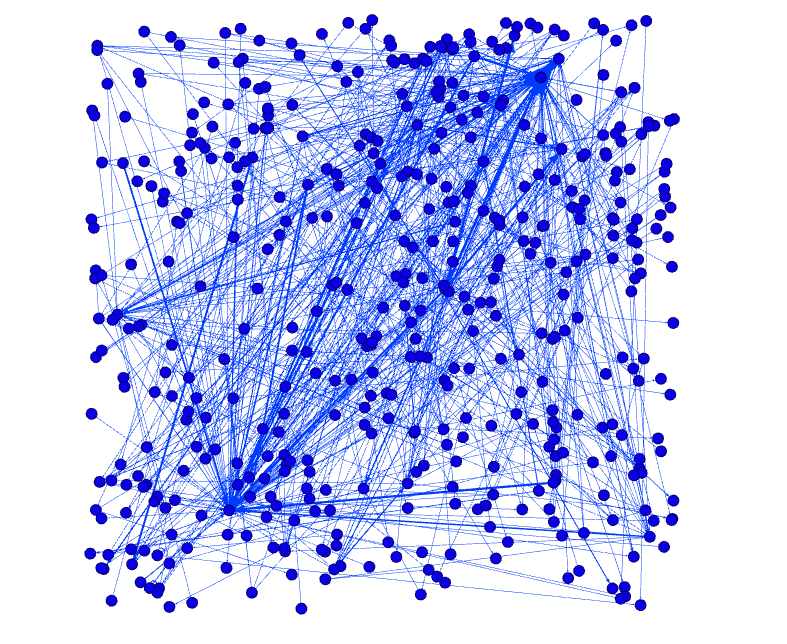

##### Statistics obtained from Gephi

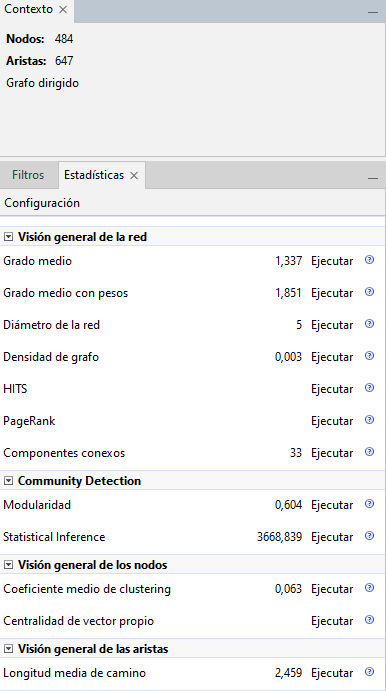

##### Size Distribution

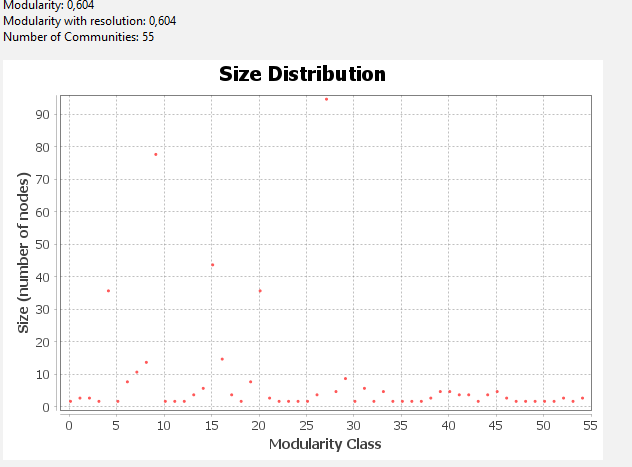

#### Hashtags

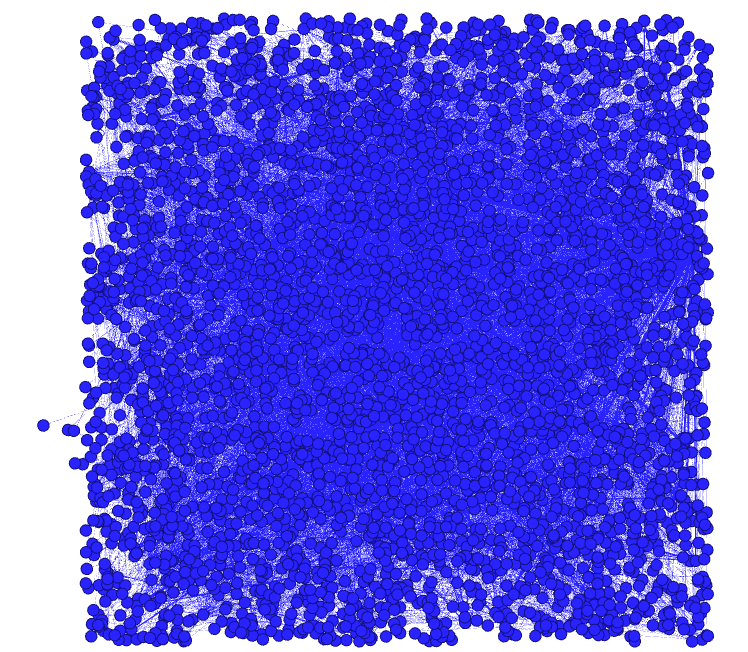

##### Statistics obtained from Gephi

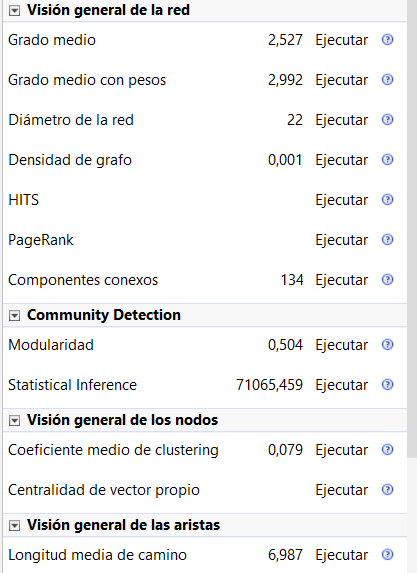

##### Size Distribution

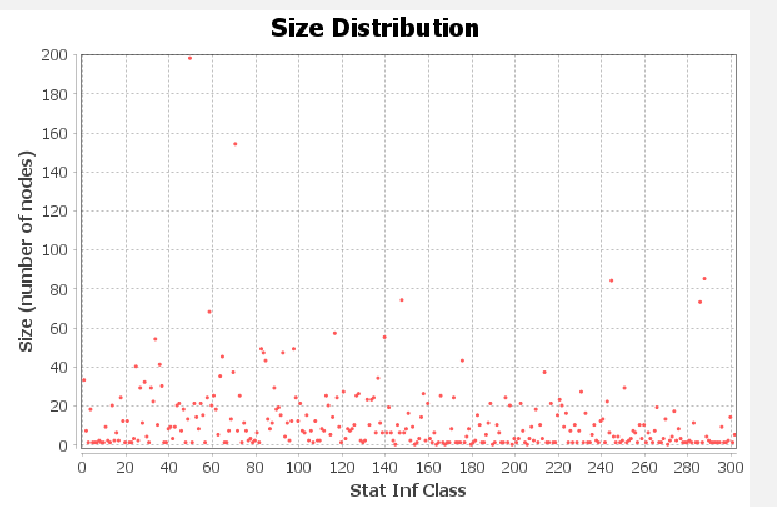